In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf

# CIFAR-10 veri setini yükle
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Veriyi düzleştir
x_train_flat = x_train.reshape(-1, 32 * 32 * 3)
x_test_flat = x_test.reshape(-1, 32 * 32 * 3)

# StandardScaler ile standartlaştırma
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Eğitim ve doğrulama veri setini ayır
x_train, x_val, y_train, y_val = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=42)

# Sınıf etiketlerini kategorik hale getir
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# RBF ile gridsearch model eğitimi

In [2]:
# x_train'in biçimini kontrol et
print(f"x_train'in tipi: {type(x_train)}, Şekli: {x_train.shape}")

x_train'in tipi: <class 'numpy.ndarray'>, Şekli: (40000, 3072)


In [8]:
x_train.var()

0.9977307

In [4]:
# RBF özel katmanını tanımla
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_centers, gamma):
        super(RBFLayer, self).__init__()
        self.num_centers = num_centers
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            shape=(self.num_centers, input_shape[-1]),
            initializer='random_normal',
            trainable=True,
            name="centers"
        )

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - self.centers
        return tf.exp(-self.gamma * tf.reduce_sum(tf.square(diff), axis=-1))

# RBF modelini tanımlayan fonksiyon
def create_rbf_model(num_centers, gamma):
    model = Sequential([
        RBFLayer(num_centers=num_centers, gamma=gamma),
        Dense(10, activation='softmax')  # Çıkış katmanı (10 sınıf için)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Grid Search parametreleri
rbf_params = {
    'num_centers': [50, 100, 200],
    'gamma': [0.1, 0.01]
}

best_accuracy = 0
best_params = None
best_rbf_model = None  # En iyi modeli saklamak için değişken oluşturduk

# Parametre kombinasyonlarını dene
for num_centers in rbf_params['num_centers']:
    for gamma in rbf_params['gamma']:
        # KMeans ile merkezleri belirlemeden önce veri tipini kontrol et
        if not isinstance(x_train, np.ndarray):
            x_train = np.array(x_train, dtype=np.float32)
        x_train = x_train.astype(np.float32)

        # KMeans ile merkezleri belirle
        kmeans = KMeans(n_clusters=num_centers, random_state=42)
        try:
            kmeans.fit(x_train)
        except ValueError as e:
            raise ValueError(f"KMeans hata verdi: {e}")

        centers = kmeans.cluster_centers_

        # Modeli oluştur ve eğit
        model = create_rbf_model(num_centers, gamma)
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                             epochs=10, batch_size=64, verbose=0)

        # Doğrulama setinde tahmin yap
        y_pred = np.argmax(model.predict(x_val), axis=1)
        y_true = np.argmax(y_val, axis=1)

        # Performans metriklerini hesapla
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        acc = accuracy_score(y_true, y_pred)

        print(f"Params: {num_centers}, Gamma: {gamma} -> Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        
        # En iyi modeli kaydet
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = (num_centers, gamma)
            best_rbf_model = model

print(f"RBF için en iyi parametreler: {best_params} -> Acc: {best_accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Params: 50, Gamma: 0.1 -> Acc: 0.0933, Precision: 0.0093, Recall: 0.1000, F1: 0.0171


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Params: 50, Gamma: 0.01 -> Acc: 0.1157, Precision: 0.1141, Recall: 0.1188, F1: 0.0447


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Params: 100, Gamma: 0.1 -> Acc: 0.0933, Precision: 0.0093, Recall: 0.1000, F1: 0.0171


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Params: 100, Gamma: 0.01 -> Acc: 0.1144, Precision: 0.1452, Recall: 0.1174, F1: 0.0452


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Params: 200, Gamma: 0.1 -> Acc: 0.0933, Precision: 0.0093, Recall: 0.1000, F1: 0.0171


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Params: 200, Gamma: 0.01 -> Acc: 0.1158, Precision: 0.1448, Recall: 0.1186, F1: 0.0492
RBF için en iyi parametreler: (200, 0.01) -> Acc: 0.1158


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step

RBF Modeli - Sınıflandırma Raporu
              precision    recall  f1-score   support

           0       0.10      0.02      0.03      1000
           1       0.11      1.00      0.19      1000
           2       0.39      0.05      0.09      1000
           3       0.11      0.00      0.01      1000
           4       0.36      0.12      0.18      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.78      0.01      0.01      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.12     10000
   macro avg       0.18      0.12      0.05     10000
weighted avg       0.18      0.12      0.05     10000



C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\besir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


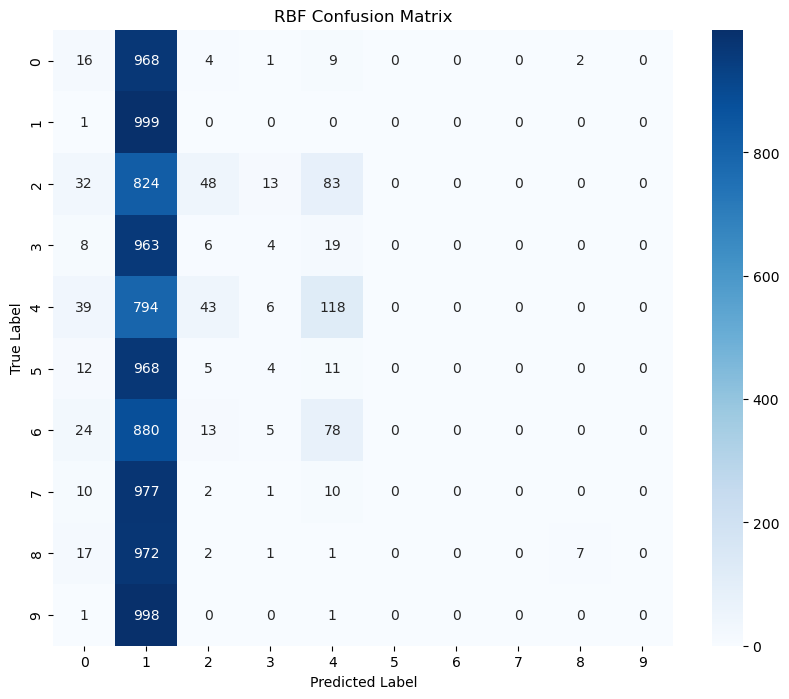

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix'i çizdirme fonksiyonu
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = range(10)  # CIFAR-10 sınıf sayısı
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# 2. RBF Modeli için en iyi sonucu elde eden modelin tahminlerini alın
rbf_y_pred = np.argmax(best_rbf_model.predict(x_test_scaled), axis=1)
rbf_y_true = np.argmax(y_test, axis=1)

print("\nRBF Modeli - Sınıflandırma Raporu")
print(classification_report(rbf_y_true, rbf_y_pred))

plot_confusion_matrix(rbf_y_true, rbf_y_pred, title="RBF Confusion Matrix")